# CC5215: Privacidad de Datos
## Laboratorio 3
**Integrantes**

- Francisco Gutiérrez Albornoz

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from unittest.mock import patch

plt.style.use('seaborn-v0_8-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

adult = pd.read_csv('https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_with_pii.csv')
adult = adult.dropna()

In [2]:
adult.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Question 1 (5 points)

Write code to answer the query: "how many participants have never been married?"

*Hint*: filter the `adult` dataframe to contain only participants who were never married, then return the  `len` of the filtered dataframe.

In [3]:
def never_married_count_query():
    return len(adult[adult['Marital Status']=='Never-married'])

never_married_count_query()

9726

In [4]:
# TEST CASE for question 1
assert never_married_count_query() == 9726

## Question 2 (5 points)

In 2-5 sentences, answer the following:
- What is the sensitivity of `never_married_count_query`, and why?


ANSWER: la sensibilidad sería 1 ya que al agregar una persona al dataset podría haberse casado o nunca haberlo hecho entonces el count query aumentaría a lo más en 1.

## Question 3 (5 points)

Use the implementation of `laplace_mech` to produce a differentially private answer to `never_married_count_query`, with `epsilon = 0.1`.

In [5]:
def dp_never_married_count_query(epsilon):
    df = 1
    return never_married_count_query() + np.random.laplace(loc=0, scale = df/epsilon)

dp_never_married_count_query(0.1)

9699.78488795031

In [6]:
# TEST CASE for question 3
dp_results = [dp_never_married_count_query(0.1) for _ in range(100)]
spec = [np.random.laplace(loc=9726, scale=1/0.1) for _ in range(100)]
assert stats.wasserstein_distance(dp_results, spec) < 10

# Question 4 (10 points)

Write the implementation of a class `DPPrinter` that collects the results of differentially private computations along with the used epsilon. Also, implement the method `print` that prints the results collected along with the total epsilon.

In [7]:
class DPPrinter():
    results = []
    epsilon = 0

    def push(self, result, eps):
        """
        Receives a differentially private result and the epsilon used to
        privatize the original result, and it stores them in the class
        """
        self.results.append(result)
        self.epsilon += eps

    def print(self):
        """
        Prints the results collected so far and the total epsilon
        """
        print('los resultados recolectados: ', self.results)
        print('epsilon total : ', self.epsilon)
printer = DPPrinter()

printer.push(dp_never_married_count_query(0.1), 0.1)
printer.push(dp_never_married_count_query(1.0), 1.0)
printer.push(dp_never_married_count_query(0.1), 0.1)

printer.print()

los resultados recolectados:  [9716.58697421154, 9725.510053793487, 9750.142494484615]
epsilon total :  1.2000000000000002


In [8]:
assert len(printer.results) == 3
assert np.isclose(printer.epsilon, 1.2)

## Question 5 (10 points)

The `pct_error` function, defined below, returns the percent relative error between an original query result and a differentially private result for the same query.

Implement a function `graph_error_never_married` that:

- Calculates 1000 differentially private answers to `dp_never_married_count_query`
- Calculates the percent error for each one of these answers against the original (non-private) answer
- Graphs the distribution of errors using a histogram

*Hint*: use `plt.hist(..., bins=20)`.

The given code will use your function to plot errors for `epsilon=0.1` and `epsilon=1.0`.

In [9]:
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

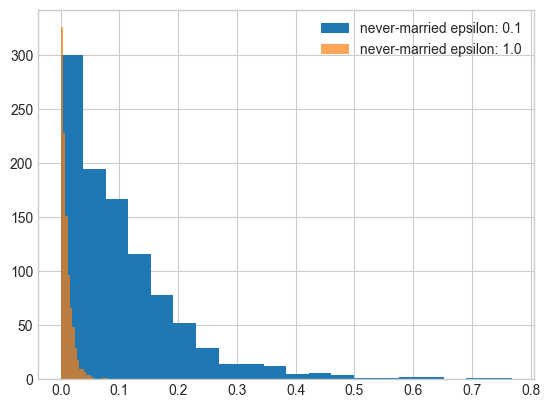

In [29]:
def graph_error_never_married(epsilon, alpha=1):
    p = DPPrinter()
    p.results = []
    p.epsilon = 0
    orig = never_married_count_query()
    for i in range(1000):
        p.push(pct_error(orig, dp_never_married_count_query(epsilon)), epsilon)
    # plt.figure()
    plt.hist(p.results, bins=20, alpha=alpha, label=f'never-married epsilon: {epsilon}')
    # plt.title(f'never married error, epsilon = {epsilon}')
    plt.legend()
    
plt.show()


graph_error_never_married(0.1)
graph_error_never_married(1.0, 0.7)

C:\Users\franc\AppData\Local\Temp\ipykernel_2096\1775630409.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


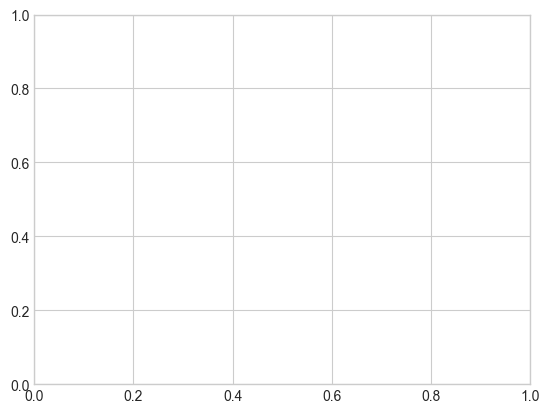

In [30]:
error_spec = 100.0 * np.abs(np.random.laplace(loc=0, scale=1, size=1000)) / never_married_count_query()

with patch('matplotlib.pyplot.hist') as mock_hist:
    graph_error_never_married(1.0)

args, kwargs = mock_hist.call_args
assert stats.wasserstein_distance(error_spec, args[0]) < 0.001

## Question 6 (10 points)

In 2-5 sentences, answer the following:

1. How does the histogram of relative errors for $\epsilon = 0.1$ differ from the one for $\epsilon = 1.0$?
2. What do the two histograms tell you about the effect of $\epsilon$ on relative error?

**HINT**: Pay close attention to which color represents which value of $\epsilon$!

ANSWER 1: en el histograma con epsilon = 1.0 se tienen valores más cercano a cero, esto es debido a que con este valor de epsilon se tiene una menor privacidad entonces se esperaría que los valores perturbados sean más parecidos a los originales. Lo contrario explicaría para epsilon=0.1, los valores no deberían parecerse tanto a los originales por tanto debería tener más error.

ANSWER 2: El tamaño de las barras, si imaginamos una envolvente para valores de epsilon cercanos a 1, la envolvente tiene una mayor pendiente (en valor absoluto), en cambio para valores de epsilon cercanos a cero la envolvente debería ser "más suave" (los errores están "más distribuidos" o "dispersos").

## Question 7 (5 points)

Consider `over_60_count_query`, which asks how many people in the dataset are over the age of 60.

In [12]:
def over_60_count_query():
    return len(adult[adult['Age'] > 60])

Implement `dp_over_60_count_query`, a differentially private version of `over_60_count_query` (as in question 3), and `graph_error_over_60`, which graphs relative error for `dp_over_60_count_query` (as in question 5).

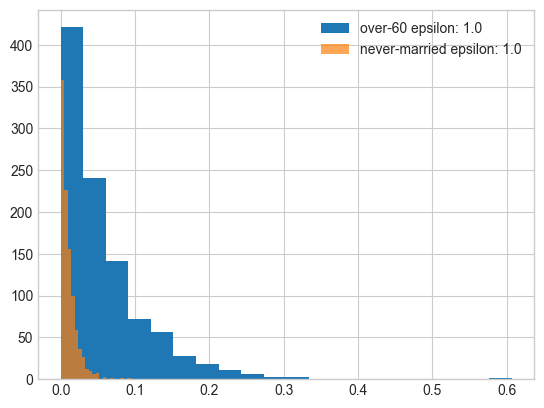

In [31]:
def dp_over_60_count_query(epsilon):
    df = 1
    return over_60_count_query() + np.random.laplace(loc=0, scale = df/epsilon)

def graph_error_over_60(epsilon, alpha=1):
    p = DPPrinter()
    p.results = []
    p.epsilon = 0
    orig = over_60_count_query()
    for i in range(1000):
        p.push(pct_error(orig, dp_over_60_count_query(epsilon)), epsilon)
    # plt.figure()
    plt.hist(p.results, bins=20, alpha=alpha, label=f'over-60 epsilon: {epsilon}')
    # plt.title(f'over 60 error, epsilon = {epsilon}')
    plt.legend()
    
plt.show()
# we plot both errors for never_married_count_query and over_60_count_query
# at the same epsilon, to compare
graph_error_over_60(1.0)
graph_error_never_married(1.0, 0.7)

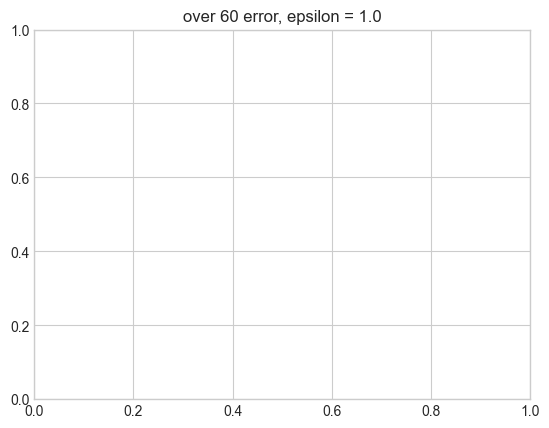

In [20]:
error_spec = 100.0 * np.abs(np.random.laplace(loc=0, scale=1, size=1000)) / over_60_count_query()

with patch('matplotlib.pyplot.hist') as mock_hist:
    graph_error_over_60(1.0)

args, kwargs = mock_hist.call_args
assert stats.wasserstein_distance(error_spec, args[0]) < 0.01

## Question 8 (10 points)

In 2-5 sentences, answer the following:

1. Given the graph from question 5, how does relative error differ between `dp_never_married_count_query` and `dp_over_60_count_query` for the same value of $\epsilon$?
2. What property of the query causes the difference in relative errors between `dp_never_married_count_query` and `dp_over_60_count_query`?

ANSWER 1: Los errores para `dp_never_married_count_query` están más concentrados que para `dp_over_60_count_query` lo que se traduce en menores errores relativos.

ANSWER 2: Puede deberse a la cantidad de valores que son entregados por la query, para `never_married_count_query()` se tienen 9726 datos, mientras que para `over_60_count_query()` 1806. Luego, para tener mayor privacidad se necesita perturbar poco los datos de la primera consulta (ya que son más) esto genera errores relativos más pequeños, lo contrario pasa para la otra query.